**Note: 3 Models trained for amazon have been saved and included if you wish to use them a line must be added to load them I haven’t done this due to the changes in required by it can be easily done if you wish**


# 1.0 Installing Dependencies

## 1.1 Pips

### yfinance

Yfinance is an API to collect market data from Yahoo Finance. Yahoo Finance is an amazing API for collecting market data, in this case I have collected the basic data (HLOCV) high, low, open, close, and volume. This data is used in all technical analysis such as technical indicators like RSI that indicates whether a stock is oversold or overpurchased. Using this information means the NN can in a way learn indicators such as this through its training process.

In [ ]:
pip install yfinance 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 KB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 46.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.2/128.2 KB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.0/111.0 KB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 KB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.2/112.2 KB 12.3 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.25.1
    Uninstalling requests-2.25.1:
      Successfully uninstalled requests-2.25.1
  Attempting uninstall: html5lib
    Found existing installation: html5lib 1.0.1
    Uninstalling html5lib-1.0.1:
      Successfully uninstalled html5lib-1.0.1
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
   

## 1.2 Imports

### General Imports
Everyday expected imports for the Project, with MeanSquaredError being a method used for interpreting accuracy of a given model

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.metrics import MeanSquaredError

### Importing External Dependencies

In [ ]:
import yfinance as yf

# 2.0 Dataset



## 2.1 Gathering

Line One Determines the Markets Data that will be train and tested on the selected NN, as explained above all the data chosen, 'Adj Close','Open', 'High', 'Low', 'Close', 'Volume' is used in technical indicators for trading therefore placing the NN on the same data set as other traders that may be interpreting share prices allowing for more indirect analysis to market trends.  Below shows the structure of the given dataset by displaying the first 10 entries available for amazon in the stock market, not the gaps after 5 consecutive days that or weekends when the NYSE (New York Stock Exchange) closes for trading.

In [ ]:
chosen_market = yf.download('AMZN') #KO (coca cola), AMZN, TSLA
market_data = chosen_market[['Adj Close','Open', 'High', 'Low', 'Close', 'Volume']].round(2)
market_data.head(10)

[*********************100%***********************]  1 of 1 completed


,Adj Close,Open,High,Low,Close,Volume
Date,,,,,,
1997-05-15,0.10,0.12,0.12,0.10,0.10,1443120000
1997-05-16,0.09,0.10,0.10,0.09,0.09,294000000
1997-05-19,0.09,0.09,0.09,0.08,0.09,122136000
1997-05-20,0.08,0.09,0.09,0.08,0.08,109344000
1997-05-21,0.07,0.08,0.08,0.07,0.07,377064000
1997-05-22,0.07,0.07,0.07,0.07,0.07,235536000
1997-05-23,0.08,0.07,0.08,0.07,0.08,318744000
1997-05-27,0.08,0.08,0.08,0.07,0.08,173952000
1997-05-28,0.08,0.08,0.08,0.08,0.08,91488000


## 2.2 Visualise the Dataset
Below is a more real to life representation of the data showing that data plotted across the years it has been traded, the price used is the price of that stock when the NYSE closed that particular day.   This is also a good time to mention the need for scaling as it the first years of the shown company the stock price is fractions to the peak, in my example here Amazon closing at £0.10 a share compared to an all-time high of roughly £175. Therefore if I was to train on this data without scaling the data there would be a heavy bias to the increases of the later years due to the changes in price per day are drastically different, MinMax Scaling solves this, I will discuss this below.  Units is dollars but I am having issues with HTML formatting for this.

5948 training data
505 test data


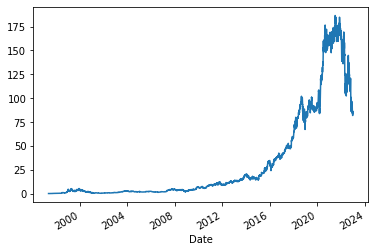

In [ ]:
print(str(market_data[:'2020'].shape[0]) + " training data")
print(str(market_data['2021':].shape[0]) + " test data")
market_data['Adj Close'].plot()

## 2.3 Prepare and Normalise the Dataset

### Formatting and Normalisation
Below I split that data to train and test sections, also saving the length of each to pass the model. My data structure is in a many to many formats due to the aim of predicting 2 days from a given 5 later using the chosen NN.   Below I restructure the collected data into a 3D array as this is the format required by Recurrent Neural Networks, the format used is Samples, Time Steps, Features. With the features being the data belonging to a given time step.   Reshaped data is then passed from the method so this can be done for any given model.

In [ ]:
def prepare_data(current_market,time_steps,for_periods):
# create training and test set
  train = market_data[:'2020'].iloc[:,0:1].values
  test  = market_data['2021':].iloc[:,0:1].values
  train_len = len(train)
  test_len = len(test)

  sc = MinMaxScaler(feature_range=(0,1))
  train_scaled = sc.fit_transform(train)

  X_train = []
  y_train = []
  for i in range(time_steps,train_len-1): 
    X_train.append(train_scaled[i-time_steps:i,0])
    y_train.append(train_scaled[i:i+for_periods,0])
  X_train, y_train = np.array(X_train), np.array(y_train)

  X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

  inputs = pd.concat((market_data["Adj Close"][:'2020'], market_data["Adj Close"]['2021':]),axis=0).values
  inputs = inputs[len(inputs)-len(test) - time_steps:]
  inputs = inputs.reshape(-1,1)
  inputs  = sc.transform(inputs)

  X_test = []
  for i in range(time_steps,test_len+time_steps-for_periods):
    X_test.append(inputs[i-time_steps:i,0])
        
  X_test = np.array(X_test)
  X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

  return X_train, y_train , X_test, sc

### Shaping Using Above Method
Below is a practical example passing the market data, number of previous days analysis and duraton of timesteps to forecast.

In [ ]:
X_train, y_train, X_test, sc = prepare_data(market_data,5,2)
X_train.shape[0],X_train.shape[1]

(5942, 5)

# 3.0 Draw Predictions vs Reality
This method takes the predictions from a given NN and plots them alongside the actual market data for the given market, giving a visual indication of how well the Model performed. The MeanSquaredAverage is also returned allowing for one technical understanding of how close the model was to a perfect score in the units of $^2 on average. MSE is used for a few reasons being a negative value should not be possible due to squaring the actual value - predicted, and the squaring of this also increases the impact of error on the value making a better model performance easier to identify. Basically acting as a measurement to the models accuracy at drawing a regression line to predict the next values in the time series.

In [ ]:
def plot_vs(predict):
  actual_pred = pd.DataFrame(columns = ['Adj. Close', 'prediction'])
  actual_pred['Adj. Close'] = market_data.loc['2021':,'Adj Close'][0:len(predict)]
  actual_pred['prediction'] = predict[:,0]

  m = MeanSquaredError()
  m.update_state(np.array(actual_pred['Adj. Close']),np.array(actual_pred['prediction']))

  return (m.result().numpy(), actual_pred.plot() )

# 4.0 Models
Models are discussed in the documentation attached, I aim to keep explanation on there as a walkthrough, technical analysis of models structure have been done on said document. Having 3 Recurrent NN gives a good opportunity to analyse each and see how changes to the structure of the hidden state affects performance in this setting.

## 4.1 (RNN) Recursive Neural Network
For RNN I have Decided to leave layers at a size of 32 to help performance this happens for a number of reason such as hardware preferring tasks in multiples of 32 due to their architecture.

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, Dropout

In [ ]:
def predict_rnn_model(X_train, y_train, X_test, sc):
  rnn_model = Sequential()
  rnn_model.add(SimpleRNN(32, return_sequences=True))
  rnn_model.add(SimpleRNN(32))
  rnn_model.add(Dense(2)) # The time step of the output

  rnn_model.compile(optimizer='rmsprop', loss='mean_squared_error')

# fit the RNN model
  rnn_model.fit(X_train, y_train, epochs=100, batch_size=150, verbose=0)

# predictions
  rnn_predictions = rnn_model.predict(X_test)
  rnn_predictions = sc.inverse_transform(rnn_predictions)

  return rnn_model, rnn_predictions

In [ ]:
fit_rnn_model, fit_rnn_predictions = predict_rnn_model(X_train, y_train, X_test, sc)

16/16 [==============================] - 0s 2ms/step


In [ ]:
fit_rnn_predictions[:10] 

array([[161.10474, 164.5615 ],
       [158.31497, 161.69463],
       [160.85745, 164.30977],
       [156.98024, 160.06856],
       [158.1479 , 161.6507 ],
       [159.29669, 162.36241],
       [155.98102, 159.13821],
       [155.40039, 158.87566],
       [158.61507, 161.72461],
       [156.95197, 159.98686]], dtype=float32)

Shows the first 50 predictions

(7.937454, <matplotlib.axes._subplots.AxesSubplot at 0x7f0f90942670>)

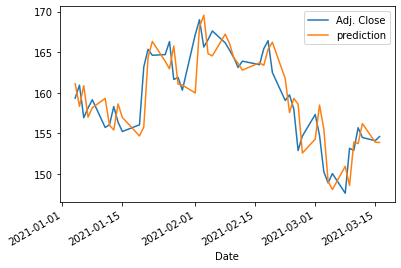

In [ ]:
plot_vs(fit_rnn_predictions[:50])  

(12.24703, <matplotlib.axes._subplots.AxesSubplot at 0x7f0f90929d00>)

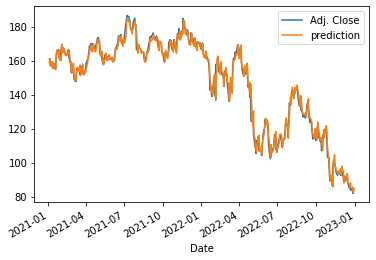

In [ ]:
plot_vs(fit_rnn_predictions)   

## 4.2 (LSTM) Long Short Term Memory

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.optimizers import SGD

In [ ]:
def predict_LSTM_model(X_train, y_train, X_test, sc):
# The LSTM architecture
  LSTM_model = Sequential()
  LSTM_model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
  LSTM_model.add(LSTM(units=50, activation='tanh'))
  LSTM_model.add(Dense(units=2))

# Compiling
  LSTM_model.compile(optimizer=SGD(learning_rate=0.01, decay=1e-7, momentum=0.9, nesterov=False),loss='mean_squared_error')

# Fitting to the training set
  LSTM_model.fit(X_train,y_train,epochs=50,batch_size=150, verbose=0)

  LSTM_prediction = LSTM_model.predict(X_test)
  LSTM_prediction = sc.inverse_transform(LSTM_prediction)

  return LSTM_model, LSTM_prediction

In [ ]:
fit_LSTM_model, fit_LSTM_prediction = predict_LSTM_model(X_train, y_train, X_test, sc)

16/16 [==============================] - 1s 3ms/step


In [ ]:
fit_LSTM_prediction[:10]

array([[157.35661, 157.87999],
       [157.99243, 158.59839],
       [157.41144, 158.03055],
       [156.03465, 156.63594],
       [154.88007, 155.4562 ],
       [154.04071, 154.58047],
       [153.63365, 154.17867],
       [152.77477, 153.2945 ],
       [152.85501, 153.38133],
       [152.60493, 153.12433]], dtype=float32)

Shows the first 50 predictions

(34.46678, <matplotlib.axes._subplots.AxesSubplot at 0x7f0f8c6900d0>)

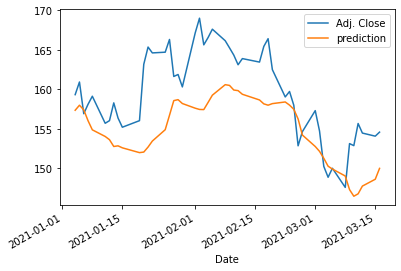

In [ ]:
plot_vs(fit_LSTM_prediction[:50])   

(54.291023, <matplotlib.axes._subplots.AxesSubplot at 0x7f0f8c5b2dc0>)

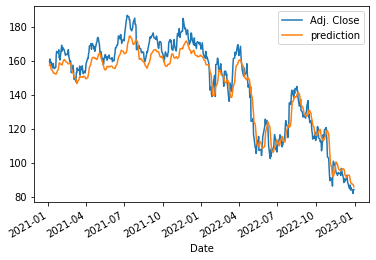

In [ ]:
plot_vs(fit_LSTM_prediction)   

### Improving LTSM using Dropout Technique
This is to avoid overfitting, and this is also implemented on GRUs second Example. Using dropout should stop overfitting by randomly removing neurons when training to stop the NN overfitting the train sample to its structure, this could make it appear that the model is great at predicting the test and train dataset but would perform worse at a later point on another dataset due to the bias created by overfitting.  

This seems to be that case too improving the performance of the models by a small amount allowing for additional fine turning of the models when training.

In [ ]:
def dropout_predict_LSTM_model(X_train, y_train, X_test, sc):
    
    from keras.models import Sequential
    from keras.layers import Dense, SimpleRNN, GRU, LSTM, Dropout
    from keras.optimizers import SGD
    
  # The LSTM architecture
    my_LSTM_model = Sequential()
    my_LSTM_model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
    my_LSTM_model.add(LSTM(units=50, activation='tanh'))
    my_LSTM_model.add(Dropout(0.2))
    my_LSTM_model.add(Dense(units=2))

  # Compiling
    my_LSTM_model.compile(optimizer=SGD(learning_rate=0.01, decay=1e-7, momentum=0.9, nesterov=False),loss='mean_squared_error')
  # Fitting to the training set
    my_LSTM_model.fit(X_train,y_train,epochs=100,batch_size=150, verbose=0)

    LSTM_prediction = my_LSTM_model.predict(X_test)
    LSTM_prediction = sc.inverse_transform(LSTM_prediction)

    return my_LSTM_model, LSTM_prediction

In [ ]:
my_LSTM_model, LSTM_prediction = dropout_predict_LSTM_model(X_train, y_train, X_test, sc)

16/16 [==============================] - 1s 3ms/step


In [ ]:
LSTM_prediction[1:10]

array([[159.15015, 159.9199 ],
       [158.52643, 159.27739],
       [157.04985, 157.77069],
       [155.80724, 156.51495],
       [154.89917, 155.60886],
       [154.4695 , 155.16112],
       [153.5485 , 154.233  ],
       [153.6311 , 154.31851],
       [153.36435, 154.04692]], dtype=float32)

(44.614906, <matplotlib.axes._subplots.AxesSubplot at 0x7f10009ba580>)

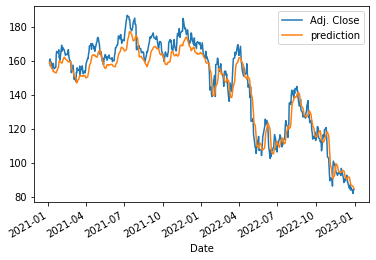

In [ ]:
plot_vs(LSTM_prediction)  

I Have Saved the best Performing of each model, all trained for 500 epoch

## 4.3 (GRU) Gated Recurrent Units 

In [ ]:
def predict_GRU_model(X_train, y_train, X_test, sc):
  from keras.models import Sequential
  from keras.layers import Dense, GRU
  from keras.optimizers import SGD
    
# The GRU architecture
  GRU_model = Sequential()
  GRU_model.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
  GRU_model.add(GRU(units=50, activation='tanh'))
  GRU_model.add(Dense(units=2))

# Compiling the RNN
  GRU_model.compile(optimizer=SGD(learning_rate=0.01, decay=1e-7, momentum=0.9, nesterov=False),loss='mean_squared_error')

# Fitting to the training set
  GRU_model.fit(X_train,y_train,epochs=50,batch_size=15, verbose=0)

  GRU_prediction = GRU_model.predict(X_test)
  GRU_prediction = sc.inverse_transform(GRU_prediction)

  return GRU_model, GRU_prediction

In [ ]:
fit_GRU_model, fit_GRU_prediction = predict_GRU_model(X_train, y_train, X_test, sc)

16/16 [==============================] - 1s 3ms/step


In [ ]:
fit_GRU_prediction[1:10]

array([[161.29008, 161.79974],
       [160.41695, 160.91695],
       [158.777  , 159.27773],
       [157.69348, 158.17076],
       [157.26457, 157.70616],
       [156.54839, 157.00694],
       [155.73647, 156.18832],
       [155.90817, 156.34096],
       [155.68756, 156.11855]], dtype=float32)

(23.967094, <matplotlib.axes._subplots.AxesSubplot at 0x7f0f89e0d6d0>)

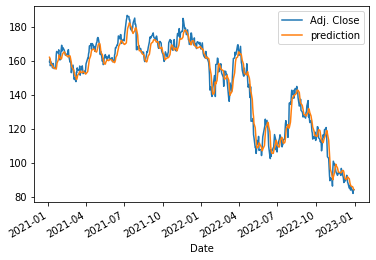

In [ ]:
plot_vs(fit_GRU_prediction) 

### GRU using Dropout
**The same as LTSM explained above**

In [ ]:

def dropout_predict_GRU_model(X_train, y_train, X_test, sc):
    from keras.layers import Dropout
    from keras.layers import GRU
    
    # The GRU architecture
    GRU_model = Sequential()
    GRU_model.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
    GRU_model.add(GRU(units=50, activation='tanh'))
    GRU_model.add(Dropout(0.2))
    GRU_model.add(Dense(units=2))
    # Compiling the RNN
    GRU_model.compile(optimizer=SGD(learning_rate=0.01, decay=1e-7, momentum=0.9, nesterov=False),loss='mean_squared_error')
    # Fitting to the training set
    GRU_model.fit(X_train,y_train,epochs=100,batch_size=15, verbose=0)

    GRU_predictions = GRU_model.predict(X_test)
    GRU_predictions = sc.inverse_transform(GRU_predictions)

    return GRU_model, GRU_predictions



In [ ]:
my_GRU_model, GRU_predictions = dropout_predict_GRU_model(X_train, y_train, X_test, sc)

16/16 [==============================] - 1s 3ms/step


In [ ]:
GRU_predictions[1:10]

array([[159.85883, 159.80719],
       [158.96547, 158.90524],
       [157.27579, 157.2207 ],
       [156.21129, 156.1579 ],
       [155.85094, 155.80241],
       [155.0773 , 155.03125],
       [154.26492, 154.22261],
       [154.47311, 154.42511],
       [154.25143, 154.20757]], dtype=float32)

(16.446804, <matplotlib.axes._subplots.AxesSubplot at 0x7f0f88468190>)

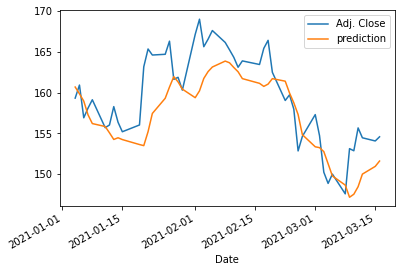

In [ ]:
plot_vs(GRU_predictions[:50])  

(26.510021, <matplotlib.axes._subplots.AxesSubplot at 0x7f0f87aecb50>)

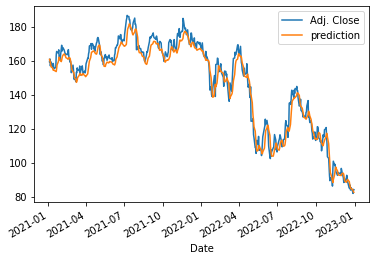

In [ ]:
plot_vs(GRU_predictions)  